## Rotate detailed morphology to align with y-axis in SWC format
This converting procedure works only for cells with a distal apical dendrite and a tuft.  

#### Function for ploting morphology from swc

In [1]:
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
%matplotlib notebook

# define plot morphology function
def plot_morphology_swc(swc_full,child_idx=None,root_id=None,ax=None,figsize=(8,6),clr=['g','r','b','c']):
    seg_type = ['soma','axon','dend','apic']
    coor3d = list('xyz')
    rm = swc_full.loc[swc_full['type']!=1,'r'].mean()
    if child_idx is None:
        swc = swc_full
    else:
        swc = swc_full.loc[child_idx]
    ilab = []
    for i in range(4):
        try:
            ilab.append(list(swc['type']==i+1).index(True))
        except:
            ilab.append(-1)
    if root_id is None:
        root_id = swc_full.index[swc_full['pid']<0][0]
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = plt.axes(projection='3d')
    else:
        fig = ax.figure
    for i, idx in enumerate(swc.index):
        label = str(ilab.index(i)+1)+': '+seg_type[ilab.index(i)] if i in ilab else None
        typeid = swc.loc[idx,'type']
        if typeid==1:
            ax.scatter(*swc.loc[idx,coor3d],c=clr[0],s=swc.loc[idx,'r']/rm,label=label)
        else:
            pid = swc.loc[idx,'pid']
            if pid is not root_id:
                line = np.vstack((swc.loc[idx,coor3d],swc_full.loc[pid,coor3d]))
                ax.plot3D(line[:,0],line[:,1],line[:,2],color=clr[typeid-1],
                          linewidth=.5*swc.loc[idx,'r']/rm,label=label)
    ax.legend()
    plt.show()
    return fig,ax

#### Load original swc file

In [2]:
import pandas as pd

# read swc file
# swc_file = 'Rorb-IRES2-Cre-D_Ai14-212873.04.01.01_510987644_m.swc'
model_name = 'neuronal_model_496930324'
# model_name = 'neuronal_model_497229089'
swc_file = model_name + '/' + 'reconstruction.swc'

swc0 = pd.read_csv(swc_file,sep=' ',skiprows=3,names='id,type,x,y,z,r,pid'.split(','),index_col='id')

# _ = plot_morphology_swc(swc0) # plot the original morphology

#### Rotate the cell to align distal apical dendrite with y-axis

In [3]:
import numpy as np
from scipy.spatial.transform import Rotation as R
from sklearn import linear_model

# function calculate rotation that moves source vector to target vector
def rotate_to_align(source,target):
    target = np.asarray(target)
    target = target/np.linalg.norm(target)
    source = np.asarray(source)
    source = source/np.linalg.norm(source)
    rotvec = np.cross(source,target)
    modulus = np.linalg.norm(rotvec)
    if modulus<1e-4:
        rot,_ = R.align_vectors(np.column_stack(target),np.column_stack(source)) # alternative method
    else:
        ang = np.sign(np.vdot(source,target))*(np.arcsin(modulus)-np.pi/2)+np.pi/2
        rot = R.from_rotvec(ang/modulus*rotvec)
    return rot

swc = swc0.copy() # to be written to new file
coor3d = list('xyz')

# children id
swc0['cid'] = [[] for _ in range(len(swc0))]
for i in swc0.index:
    pid = swc0.loc[i,'pid']
    if pid>0:
        swc0.loc[pid,'cid'].append(i)

# distance to soma
soma_id = swc0.index[swc0['type']==1][0] # soma index
soma = swc0.loc[soma_id,coor3d] # soma coordinates
centered_coord = (swc0[coor3d]-soma).astype('float64') # translate soma to the origin
swc0['dist'] = np.linalg.norm(centered_coord,axis=1) # distance to the soma

# find id of the segment of the first branch at distal apical dendrite and choose it as the end point
max_dist = np.max(swc0['dist'])
# search in segment further than half of the furthest segment distance
end_pt_id = swc0.index[((swc0['dist']>max_dist/2) & (len(swc0['cid'])>1) & (swc0['type']==4)).tolist().index(True)]

# rotate the cell to make apical dendrite align with y-axis and write to a new dataframe
cell_orien = np.array([0.,1.,0.]) # target orientation (rotate to align with y-axis)
orien = centered_coord.loc[end_pt_id] # end point orientation
rot2y = rotate_to_align(orien,cell_orien)
swc[coor3d] = rot2y.apply(centered_coord)

# rotate about y axis to put basal dendrites around xy-plane
basal = swc.index[swc['type']==3]
lreg = linear_model.LinearRegression(fit_intercept=False)
lreg.fit(swc.loc[basal,'x'].values.reshape(-1,1),swc.loc[basal,'z'].values.reshape(-1,1))
rot_y = R.from_euler('y',np.arctan(lreg.coef_[0,0]))
swc[coor3d] = rot_y.apply(swc[coor3d])

# The rotation representations below can be read by BMTK
rot = rot_y*rot2y # compose two rotations
print(rot.apply(orien)) # check final end point position after rotation (should be close to [0,y,0])
rot_zyx = rot.as_euler('zyx') # rotation angles around z then y then x 
# quaternion = rot.as_quat() # quaternion representation of rotation

[-1.35780276e-13  2.72432429e+02 -1.73194792e-14]


In [4]:
# save rotated swc file
try:
    rot_file = 'sim_details/components/morphologies/' + model_name + '_rotate.swc'
except:
    rot_file = 'sim_details/components/morphologies/' + swc_file[:swc_file.find('.swc')] + '_rotate.swc'
        
with open(swc_file,'r') as f:
    lines = [next(f) for i in range(3)]

with open(rot_file,'w') as f:
    for line in lines:
        f.write(line)
swc.to_csv(rot_file,sep=' ',header=False,float_format='%.4f',mode='a')

#### Plot rotated morphology

In [5]:
# children id
swc['cid'] = [[] for _ in range(len(swc))]
for i in swc.index:
    pid = swc.loc[i,'pid']
    if pid>0:
        swc.loc[pid,'cid'].append(i)

# distance to soma
coor3d = list('xyz')
soma_id = swc.index[swc['type']==1][0] # soma index
soma = swc.loc[soma_id,coor3d] # soma coordinates
swc['dist'] = np.linalg.norm((swc[coor3d]-soma).astype(float),axis=1)

# find id of the segment of the first branch at distal apical dendrite and choose it as the end point
max_dist = np.max(swc['dist'])
# search in segment further than half of the furthest segment distance
end_pt_id = swc.index[((swc['dist']>max_dist/2) & (len(swc['cid'])>1) & (swc['type']==4)).tolist().index(True)]

# calculate length of each segment
swc['L'] = np.zeros((len(swc),1))
nonsoma = swc['type'].values>1
swc.loc[swc.index[nonsoma],'L'] = np.linalg.norm(swc.loc[nonsoma,coor3d].values-swc.loc[swc[nonsoma]['pid'],coor3d].values,axis=1)

In [6]:
# function find all chidren given a root segment id
def all_children(df,pid,cids=None):
    if cids is None:
        cids = np.zeros(len(df),dtype=bool)
    for cid in df.loc[pid,'cid']:
        cids[df.index.get_loc(cid)] = True
        all_children(df,cid,cids=cids)
    return cids

# function find all parents till soma given a segment id
def all_parents(df,cid):
    pids = np.zeros(len(df),dtype=bool)
    pid = df.loc[cid,'pid']
    p0id = df.loc[pid,'pid']
    while p0id>0:
        pids[df.index.get_loc(cid)] = True
        cid = pid
        pid = p0id
        p0id = df.loc[p0id,'pid']
    return pids

In [7]:
# find the sections
axon = np.asarray(swc['type']==2)
basal = np.asarray(swc['type']==3)
tuft = all_children(swc,end_pt_id) # bool array
trunk = all_parents(swc,end_pt_id)
apical = np.asarray((swc['type']==4) & (~tuft) & (~trunk))

<IPython.core.display.Javascript object>


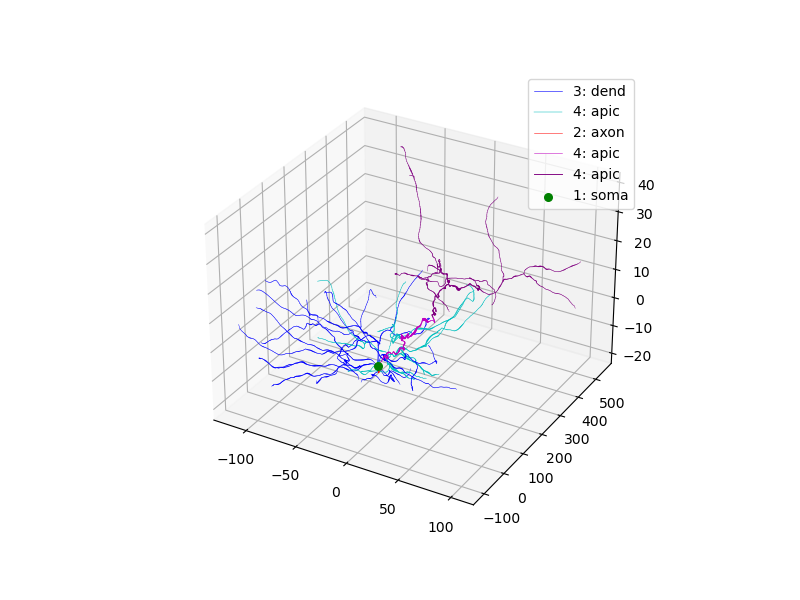

In [8]:
# plot tuft
fig,ax = plot_morphology_swc(swc,child_idx=~(tuft|trunk))
_ = plot_morphology_swc(swc,child_idx=trunk,root_id=soma_id,ax=ax,clr=['g','r','b','m'])
_ = plot_morphology_swc(swc,child_idx=tuft,root_id=end_pt_id,ax=ax,clr=['g','r','b','purple'])

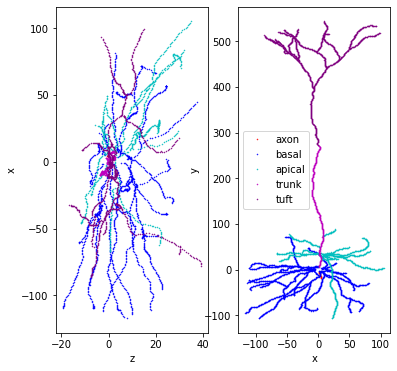

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(6,6))
plt.subplot(121)
plt.plot(swc.loc[axon,'z'],swc.loc[axon,'x'],'r.',label='axon',markersize=1)
plt.plot(swc.loc[basal,'z'],swc.loc[basal,'x'],'b.',label='basal',markersize=1)
plt.plot(swc.loc[apical,'z'],swc.loc[apical,'x'],'c.',label='apical',markersize=1)
plt.plot(swc.loc[trunk,'z'],swc.loc[trunk,'x'],'m.',label='trunk',markersize=1)
plt.plot(swc.loc[tuft,'z'],swc.loc[tuft,'x'],'.',color='purple',label='tuft',markersize=1)
plt.xlabel('z')
plt.ylabel('x')
plt.subplot(122)
plt.plot(swc.loc[axon,'x'],swc.loc[axon,'y'],'r.',label='axon',markersize=1)
plt.plot(swc.loc[basal,'x'],swc.loc[basal,'y'],'b.',label='basal',markersize=1)
plt.plot(swc.loc[apical,'x'],swc.loc[apical,'y'],'c.',label='apical',markersize=1)
plt.plot(swc.loc[trunk,'x'],swc.loc[trunk,'y'],'m.',label='trunk',markersize=1)
plt.plot(swc.loc[tuft,'x'],swc.loc[tuft,'y'],'.',color='purple',label='tuft',markersize=1)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc=0)
plt.show()